In [120]:
import json
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from augur.utils import json_to_tree
from Bio import Phylo, SeqIO
from scipy import stats


import baltic as bt

# Figure 1: Adaptive mutations accumulate continuously over time in known adaptively-evolving proteins

Plot the estimated number of adaptative mutations over time in the receptor-binding protein and polymerase. Plot both the Bhatt rate and the new method for estimating rates of adaptation, which takes into account recurring mutations at the same codon position.

In [26]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [27]:
def standardize_gene_name_reverse(virus, gene):
    
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {x: configs[x]['virus_gene'] for x in genes}
    
    return gene_names[gene]

In [28]:
def standardize_gene_name(virus, gene):
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {configs[x]['virus_gene']:x for x in genes}
    
    return gene_names[gene]

In [29]:
def get_data_from_both_methods(virus, subtype, gene, window, min_seqs, 
                        midfreq_high, midfreq_low, year_max, year_min):
    """
    Read in the adaptation results from both the standard Bhatt method and the new method. 
    Store data at each time point.
    
    Rate of adaptation analysis (and bootstraps) must already have been run and saved.
    """
    
    all_timepoints = []
    
    if subtype==None:
        virus_subtype = virus
        virus_and_subtype = virus
    else:
        virus_subtype = subtype
        virus_and_subtype = virus+'_'+subtype
    
    bhatt_json_name = f'bhatt_results/bhatt_results_nextstrain_{window}_{min_seqs}/{virus_and_subtype}_{gene}_bhatt_analysis_bootstrapped.json'
    if path.exists(bhatt_json_name):
        with open(bhatt_json_name) as bhatt_handle:
            json_dict = json.load(bhatt_handle)
            (bhatt_window_midpoint, bhatt_adaptive_substitutions, 
             bhatt_adaptive_substitutions_per_codon, 
             bhatt_rate_of_adaptation, bhatt_bootstrap_adaptive_substitutions, 
             bhatt_bootstrap_adaptive_substitutions_per_codon, 
             bhatt_bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

    else:
        print(f'{virus_and_subtype} {gene} Bhatt analysis has not been run')

    for t in range(len(bhatt_window_midpoint)):
        for x in bhatt_bootstrap_adaptive_substitutions_per_codon:
            all_timepoints.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                                   'gene': standardize_gene_name(virus, gene), 
                                   'timepoint': bhatt_window_midpoint[t],
                                   'method': 'bhatt',
                                   'adaptive_subs_per_codon': bhatt_adaptive_substitutions_per_codon[t], 
                                   'bootstrap_adaptive_subs_per_codon': x[t], 
                                   'rate_of_adaptation': bhatt_rate_of_adaptation})

    kistler_json_name = f'adaptation_results/results/{virus_and_subtype}_{gene}_{window}_{min_seqs}_adaptation_bootstrapped.json'

    if path.exists(kistler_json_name):
        with open(kistler_json_name) as kistler_handle:
            json_dict = json.load(kistler_handle)
            (kistler_window_midpoint, kistler_adaptive_substitutions, 
             kistler_adaptive_substitutions_per_codon, 
             kistler_rate_of_adaptation, kistler_bootstrap_adaptive_substitutions, 
             kistler_bootstrap_adaptive_substitutions_per_codon, 
             kistler_bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

    else:
        print(f'{virus_and_subtype} {gene} Kistler analysis has not been run')

    for t in range(len(kistler_window_midpoint)):
        for x in kistler_bootstrap_adaptive_substitutions_per_codon:
            all_timepoints.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                                   'gene': standardize_gene_name(virus, gene), 
                                   'timepoint': kistler_window_midpoint[t],
                                   'method': 'kistler',
                                   'adaptive_subs_per_codon': kistler_adaptive_substitutions_per_codon[t], 
                                   'bootstrap_adaptive_subs_per_codon': x[t], 
                                   'rate_of_adaptation': kistler_rate_of_adaptation})





    return all_timepoints


In [164]:
def plot_adaptive_muts(virus, gene_to_plot, ax, method='kistler'):
    
    """
    Plot the accumulation of adaptive mutations over time for the specified virus.
    
    Plot the results of both methods for estimating the rate of adaptation (update outgroup and constant outgroup).
    
    Plot the empirical data points the line fitting them. 
    For the 100 bootstrap iterations, plot just the line fitting the points.
    """
    #standard params for how the adaptation analysis was run
    window = 5
    min_seqs = 3
    midfreq_high = 0.75
    midfreq_low = 0.15
    year_max = None
    year_min=None
    exclude = []
    
    #for viruses with under 12 years of analysis, use smaller windows
    if virus in ['h1n1pdm', 'mumps']:
        window, minseqs = 3, 3
    #get the name of the polymerase or receptor-binding gene
    gene = standardize_gene_name_reverse(virus, gene_to_plot)
    
    #read in the configs for this virus
    configs = readin_virus_config(virus)
    
    virus_color = configs['color']
    
    data_to_plot = []
        
    if configs['subtype']=='True':
        subtypes = configs['subtypes']
        for subtype in subtypes:
            virus_and_sub = virus+'_'+subtype
            if virus_and_sub not in exclude:
                if gene!="None":
                    data_to_plot+=get_data_from_both_methods(virus, subtype, gene, window, 
                                                         min_seqs, midfreq_high, midfreq_low, year_max, year_min)
    else:
        subtype=None
        if virus not in exclude:
            if gene!="None":
                data_to_plot+=get_data_from_both_methods(virus, subtype, gene, window, 
                                                     min_seqs, midfreq_high, midfreq_low, year_max, year_min)

    df_to_plot = pd.DataFrame(data_to_plot)

        
    #subset data to only the specified method
    subset_data = df_to_plot[df_to_plot['method']==method]
    rate = subset_data['rate_of_adaptation'].unique()[0]
    rate = f'{round(rate*1000,2)} × ' + r'$10^{-3}$'
    
    
    #get data to plot
    X = subset_data['timepoint']
    Y = subset_data['adaptive_subs_per_codon']
    #get linear fit
    coef = np.polyfit(X, Y, 1)
    poly1d_fn = np.poly1d(coef)
    
    #subset data into "intial period" and "subsesequent period" and calculate rate separately
    three_years_past_start = subset_data['timepoint'].min()+3
    initial_period = subset_data[subset_data['timepoint']<=three_years_past_start]
    X_initial = initial_period['timepoint']
    Y_initial = initial_period['adaptive_subs_per_codon']
    #get linear fit
    coef_initial = np.polyfit(X_initial, Y_initial, 1)
    poly1d_fn_initial = np.poly1d(coef_initial)
    rate_initial = f'{round(coef_initial[0]*1000,2)} × ' + r'$10^{-3}$'
    

    subsequent_period = subset_data[subset_data['timepoint']>three_years_past_start]
    X_subsequent = subsequent_period['timepoint']
    Y_subsequent = subsequent_period['adaptive_subs_per_codon']
    #get linear fit
    coef_subsequent = np.polyfit(X_subsequent, Y_subsequent, 1)
    poly1d_fn_subsequent = np.poly1d(coef_subsequent)
    rate_subsequent = f'{round(coef_subsequent[0]*1000,2)} × ' + r'$10^{-3}$'
    
    
    
    ax.plot(X, Y, 'o', ms=8, color='white', markeredgewidth=1.0, markeredgecolor=virus_color)
    ax.plot(X, poly1d_fn(X), '--', linewidth=2.5, color='#808080')
    ax.plot(X_initial, poly1d_fn_initial(X_initial), '-', linewidth=2, color='#F5AD52')
    ax.plot(X_subsequent, poly1d_fn_subsequent(X_subsequent), '-', linewidth=2, color='#208288')
    
    # label rate
    ax.text(0.05, 0.9, f'overall rate = {rate}', fontsize=10, color='#808080', transform=ax.transAxes)
    ax.text(0.05, 0.8, f'initial = {rate_initial}', fontsize=10, color='#F5AD52', transform=ax.transAxes)
    ax.text(0.05, 0.7, f'subsequent = {rate_subsequent}', fontsize=10, color='#208288', transform=ax.transAxes)


    
    

    
    # remove box around plot
    sns.despine(left=False, bottom=False)


In [165]:
def plot_adaptive_muts_over_time(viruses, filename=False):
    
    fig, axs = plt.subplots(1,2, figsize=(8,3))
    

    
    #prettify virus name
    virus_name = {'h3n2': 'Influenza\nA/H3N2','h1n1pdm': 'Influenza\nA/H1N1pdm'}
    
    #plot text styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    
    plt.rcParams['figure.dpi']= 300
    
    
    for i in range(len(viruses)):
        virus = viruses[i]

        #plot adaptive mutation accumulation in polymerase in the third
        plot_adaptive_muts(virus, 'receptor_binding', axs[i])
        axs[i].set_title(virus_name[virus])
        if i==0:
            axs[i].set_ylabel("Adaptive Mutations \n per Codon")
        else:
            axs[i].set_ylabel("")
            
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
        
        

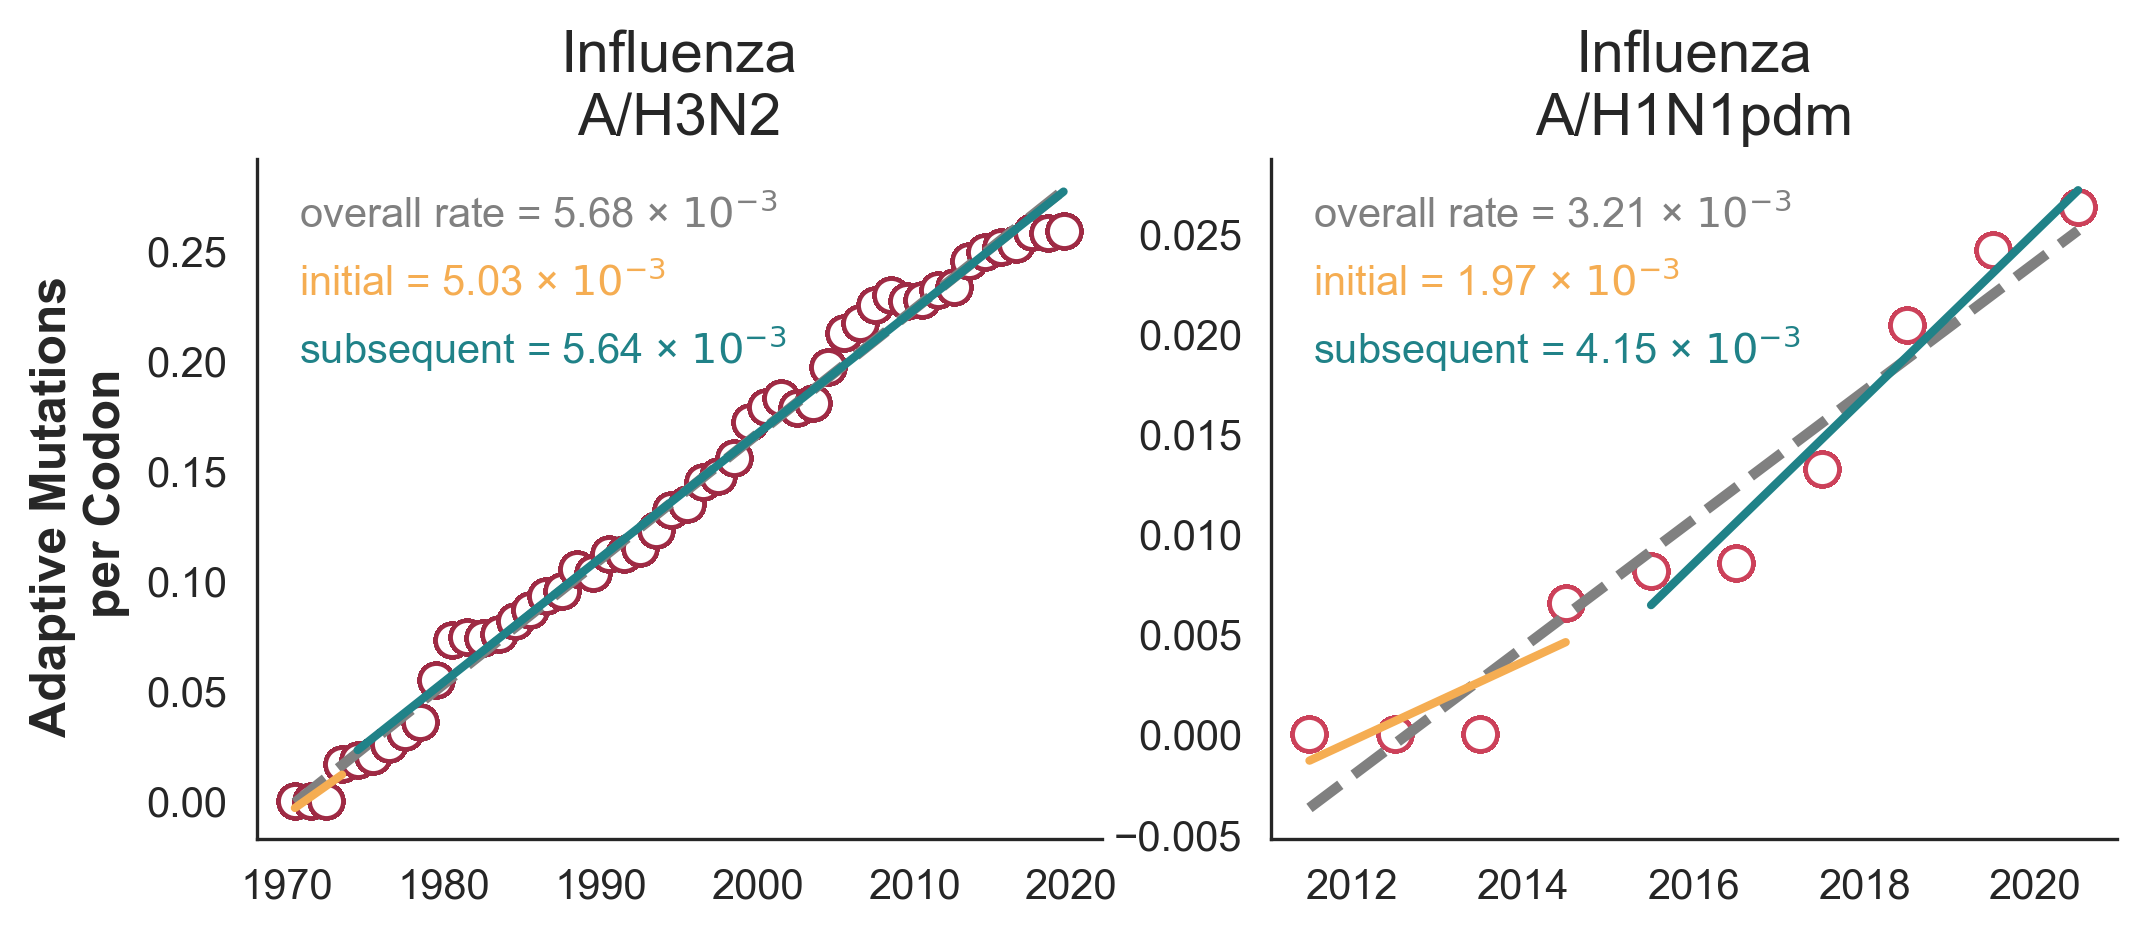

In [169]:
#constant outgroup in gray
plot_adaptive_muts_over_time(['h3n2', 'h1n1pdm'])